# Image Classification With A Deep Convolutional Neural Network (AlexNet)
This notebook details the steps taken to implement and train a Deep Neural Network(DNN) on the [Cifar-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset in order to perform the computer vision task of image classification on the Cifar-10 test dataset partition. 

To build, train and test a neural network, the libraries TensorFlow and Keras are leveraged to provide the features and methods required to build the components of a neural network. Supporting libraries such as Matplotlib and Numpy are utlised for visualisation and data processing

**[TensorFlow](https://www.tensorflow.org/)**: An open-source platform for implementing, training, and deploying machine learning models.

**[Keras](https://keras.io/)**: An open-source library used to implement neural network architectures that run on both CPUs and GPUs.

**[Matplotlib](https://matplotlib.org/)**: Tool utilized to create visualization plots in Python such as charts, graphs and more

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time

## Cifar-10 Dataset

The [Cifar-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset consists of images of animals and everyday vehicles.
The dataset was put together by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. More specifically, it contains 50,000 training examples and 10,000 testing examples, that are all color images with the dimension 32 x 32 categorized into 10 classes.

[**Keras Dataset**](https://keras.io/api/datasets/) (keras.datasets)

In the practical world of machine learning, obtaining dataset is costly in terms of time, money and effort.
But a few introductory datasets have been collated together to help students and researchers build and analyse the performance of models on specifics datasets.
Some of these dataset reside within the Keras API and are easily accessible through the [load_data()](https://keras.io/api/datasets/cifar10/#loaddata-function) method of each respective dataset.

To load the Cifar-10 dataset: `keras.datasets.cifar10.load_data()`

**Classes**
| Label | Description |
|-------|-------------|
| 0     | airplane    |
| 1     | automobile  |
| 2     | bird        |
| 3     | cat         |
| 4     | deer        |
| 5     | dog         |
| 6     | frog        |
| 7     | horse       |
| 8     | ship        |
| 9     | truck       |

**Dataset Partitions**

For this particular classification task, 45,000 training images, 10,000 test images, and 5,000 validation images are utilized.
- Training Data: This is the group of our dataset used to train the neural network directly. Training data refers to the dataset partition exposed to the neural network during training.
- Validation Data: This group of the dataset is utilized during training to assess the performance of the network at various iterations.
- Test Data: This partition of the dataset evaluates the performance of our network after the completion of the training phase.

**The code snippet below unpacks the tuple of numpy arrays that correspons to the training images and labels, as well as the testing images and labels**

In [2]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

In [3]:
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Validation Data
The validation partition of the dataset is obtained from taking a slice of the training data. More specifically, the first 5000 training images and labels are assigned to the validation data.
The new training data is reassigned to every training data element but the first 5000 images in the original training data.

In [4]:
validation_images, validation_labels = train_images[:5000], train_labels[:5000]
train_images, train_labels = train_images[5000:], train_labels[5000:]

## Input Pipeline and TensorFlow Dataset

Input pipelines are used as a method of streaming data to a model in an automated fashion. Input pipelines can be made responsible for the automation of preprocessing steps taken on input data before presented to the network during training.

In this notebook we create input pipelines for our training, testing and validation data using the [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) API. With well constructed pipelines transformations and augmentation can be made to data points or batches of the dataset partitions in an memory efficient manner.

The source of the data used to create the Dataset Object for our input pipeline is the numpy arrays of the dataset partitions created in the cells above. More specfically the `tf.data.Dataset.from_tensor_slices()` allows for the creation of the required Dataset object.

Below we create the Dataset Objects `train_da`, `test_ds` and `validation_ds` which represent the input pipelines for the training, testing and validation data respectively.

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

## Visualising Training Data

The Dataset object returned tf.data.Dataset can be iterated over, so we can view a portion of the dataset using pyplot.

Below is a visualisation of the first five images and corresponding labels.

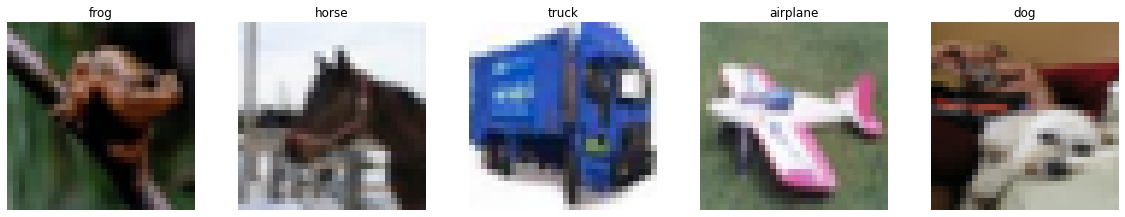

In [6]:
plt.figure(figsize=(20,20))
for i, (image, label) in enumerate(train_ds.take(5)):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label.numpy()[0]])
    plt.axis('off')

## Image Preproccessing

**Standardization**
The TensorFlow module [tf.image](https://www.tensorflow.org/api_docs/python/tf/image) provides a suite of processing and transformation functions that can be applied on image dataset, so resizing, recoloring, cropping and other common transformation become trivial. 

In this notebook the images are resized from the original dimensions of 32x32 to 227x227, this is because the input layer of the AlexNet architecture expects images of size 227x227. In addition to resizing, the images are normalized to have a mean of 0 and standard deviation of 1

In [7]:
def image_preprocessing(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    # Resize images from 32x32 to 277x277
    image = tf.image.resize(image, (227,227))
    return image, label

### Finializing the Input pipelines


The input pipelines required for this notebook will automate the following
- **Transformation** based on custom function `image_preprocessing` passed into [Dataset.map()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) method.
- **Caching** the dataset after the first pass through all data points, this is done using the [Dataset.cache()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) method.
- **Shuffling** of the dataset to ensure the elements are randomized, this is done using the [Dataset.shuffle()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle). The `buffer_size` argument specifies the number of element passed into the buffer from which random elements are selected.
- **Batching** of the dataset in order to present input data in samples set. The batch size is specified by the `batch_size` argument of the [Dataset.batch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) method .

In [8]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()
print("Training data size:", train_ds_size)
print("Test data size:", test_ds_size)
print("Validation data size:", validation_ds_size)

Training data size: 45000
Test data size: 10000
Validation data size: 5000


In [9]:
train_ds = (train_ds
                  .map(image_preprocessing)
                  .cache()
                  .shuffle(buffer_size=train_ds_size, reshuffle_each_iteration=True)
                  .batch(batch_size=32, drop_remainder=True))

test_ds = (test_ds
                  .map(image_preprocessing)
                  .cache()
                  .shuffle(buffer_size=train_ds_size, reshuffle_each_iteration=True)
                  .batch(batch_size=32, drop_remainder=True))

validation_ds = (validation_ds
                  .map(image_preprocessing)
                  .cache()
                  .shuffle(buffer_size=train_ds_size, reshuffle_each_iteration=True)
                  .batch(batch_size=32, drop_remainder=True))

## Convolutional Neural Network Implementation(CNN) Components

1. [ Keras Layers API](https://keras.io/api/layers) (keras.layers)
    
    Layers within Keras allow for the composition of neural networks as they are the fundamental components of neural networks in Keras.
    Layers within Keras also house the following: weights of the neural network and functions that act upon inputs and provide outputs, typically to the next layer.
    
2. [Conv2D Layer](https://keras.io/api/layers/convolution_layers/convolution2d/) (keras.layers.Conv2D)

    We are using the tf.keras.layers.Conv2D class to construct the convolutional layers within the convolutional neural network.
    In the convolutional layer, a convolution operation takes place between the input image and the kernel/filter of the conv layer. The output of the convolutional layer is the result of the convolution operation between the input data and the values of the kernel/filter.

    The Conv2D class constructor `keras.layers.Conv2D` takes several arguments. Below are the ones used within this notebook
    - `filters`: The kernel/filter is the name given to the window containing the weight values utilized during the convolution of the weight values with the input values. 
    - `kernel_size`: Indicative of each unit or neuron's local receptive field size within a convolutional layer. 
    - `strides`: Defines the amount of shift the filter/sliding window takes over the input image.
    - `activation`: A mathematical operation that transforms the result or signals of neurons into a normalized output.
    - `input_shape`: The expected shape of the input data to be fed forward through the neural network.
    - `padding`: An assigned value of 'same' results in the output shape of the layer been the same as the input, as the output data is padded with zeros around the edges. An assigned value of 'valid' will indicate no padding should be assigned to the output, resulting in the filter/kernel of the convolutional layer only operating parts of the input image that covers the filter/kernel size.


3. [BatchNormalization Layer](https://keras.io/api/layers/normalization_layers/batch_normalization/) (keras.layers.BatchNormalization)
    
    Batch Normalization(BN) is a technique that mitigates the effect of unstable gradients within deep neural networks. BN introduces an additional layer to the neural network that performs operations on the inputs from the previous layer.
    The operation standardizes and normalizes the input values. The input values are then transformed through scaling and shifting operations.
    The technique batch normalization was presented in 2015 by Christian Szegedy and Sergey Ioffe in this [paper](https://arxiv.org/pdf/1502.03167.pdf).

4. [Max Pooling Layer](https://keras.io/api/layers/pooling_layers/max_pooling2d/) (keras.layers.MaxPool2D)

    Max pooling is a type of sub-sampling where the maximum pixel value of a set of pixels that fall within the receptive field of a unit within a sub-sampling layer is taken as the output.
    
    | 30 | 28  | 28 | 184 |
    |----|-----|----|-----|
    | 0  | 100 | 12 | 98  |       
    | 12 | 11  | 9  | 4   |
    | 12 | 1   | 45 | 6   |

    The above pixel values transform to the set of pixel values below with the max-pooling operation.
    
    | 100 | 184 |
    |-----|-----|
    | 12  | 45  |

    The max-pooling layer constructor `keras.layers.MaxPool2D` expects the following arguments
    - `pool_size`: Dimensions of the sliding window that performs a mathematical operation within pixel values that falls within it.
    - `strides`: Indicates the amount the pooling window moves across the input data after the evaluation of each pooling operation.
    
5. [Flatten Layer](https://keras.io/api/layers/reshaping_layers/flatten/) (keras.layers.Flatten)

    The  Flatten layer is known as one of the reshaping layers Keras provides to modify the dimensionalities of inputs.
    The Flatten class acts upon the inputs by reducing the dimensionality of the input data to one.
    Image datasets are multidimensional, and for input data to be fed forward through the neural network, the dimensions of the input data need to be reduced to one. We essentially require our input data to be 1-dimensional.
    For example, an input to the Flatten layer with the shape (None, 10, 2) will provide the output (None, 20).

    The input shape of the first layer of a neural network should match the shape of the input data; hence the 'input_shape' attribute of the Flatten layer is (28,28) when using the FashionMNIST dataset (shown in the notebook 02_image_classification_with_DNN).

6. [Dense Layer](https://keras.io/api/layers/core_layers/dense/) (keras.layers.Dense)

    The dense layer houses neurons within the neural network. The 'unit' attribute specifies the number of neurons within a dense layer. All neurons/units within the dense layer receive input from the previous layer.
    The dense layer operation on its input is a matrix-vector multiplication between the input data, learnable weights of the layer, and biases.

7. [Activation Functions](https://keras.io/api/layers/activations/) (keras.activations.relu / keras.activations.softmax)

    Activation Function: A mathematical operation that transforms the result or signals of neurons into a normalized output. An activation function is a component of a neural network that introduces non-linearity within the network. The inclusion of the activation function enables the neural network to have greater representational power and solve complex functions.

    **Examples of Activation functions**

    ReLU activation: Stands for ‘rectified linear unit’ ( y=max(0, x)). It's a type of activation function that transforms the value results of a neuron. The transformation imposed by ReLU on values from a neuron is represented by the formula y=max(0,x). The ReLU activation function clamps down any negative values from the neuron to 0, and positive values remain unchanged. This mathematical transformation is utilized as the output of the current layer and as input to the next.

    Softmax: An activation function that derives the probability distribution of a set of numbers within an input vector. The output of a softmax activation function is a vector whose set of values represents the probability of an occurrence of a class/event. The values within the vector all add up to 1.

8. [Dropout Layer](https://keras.io/api/layers/regularization_layers/dropout/) (keras.layers.Dropout)

    Dropout is a technique that is utilized to reduce a model's potential to overfit.
    The dropout technique works by adding a probability factor to the activation of neurons within the layers of a CNN. This probability factor indicates the neurons' chances of being activated during a current feedforward step and during the process of backpropagation.
    Dropout is useful as it enables the neurons to reduce dependability on neighbouring neurons; each neuron learns more useful features due to this.

**Below is a deep convolutional neural network implementation using all the layers and components described above**

In [10]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

## TensorBoard

TensorBoard provides visual insights into the events that occur during training at each epoch.
The training visualization provided by TensorBoard is stored in a ‘runs’ folder directory. We create a function to generate a folder directory and identify each log via a timestamp.

**Run Tensorboard using the command below from the location of the run folder on the terminal**
`tensorboard --logdir='runs'`


In [11]:
# Configure TensorBoard storage location
root_logdir = os.path.join(os.curdir, "runs")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

## Neural Network Hyperparameters and More
### Compilation
Keras provides the `Model.compile()` method which is available to the `model` object instantiated earlier in this notebook. The compile function enables the actual building of the model we have implemented behind the scene with some additional characteristics such as the `loss` function, `optimizer`, and metrics.

To train the network, we utilize a loss function that calculates the difference between the predicted values provided by the network and actual values of the training data.

The `learning rate` loss values and the optimizer algorithm facilitates the number of changes made to the weights within the network. 

Supporting factors such as `momentum` and `learning rate schedule`, provide the ideal environment to enable the network training to converge, herby getting the training loss values as close to zero as possible.

### Definitions
* **Learning Rate**: An integral component of a neural network as it’s a factor value that determines the level of updates that are made to the values of the weights of the network.

    In a visualization exercise, the function to be solved can be depicted as a hyperbolic curve in n-dimensional parameter space.
    The learning rate is a component that affects the step size that the current parameter values take towards a local/global minima; hence the learning rate directly affects the rate of convergence of a network during training. 

    If the learning rate is too small the network might take several iterations and epochs to converge. On the other hand, if the learning rate is too high, there is a risk of overshooting the minima, and as a result of this our training doesn’t converge. Selecting the appropriate learning rate can be a time staking exercise.
    
* **Learning rate schedule**: A constant learning rate can be utilized during the training of a neural network, but this can increase the amount of training that has to take place to arrive at optimal neural network performance. By utilizing the learning rate schedule, we introduce a timely reduction or increment of the learning rate during training to arrive at an optimal training outcome of the neural network.

* **Learning rate Decay**: Learning rate decay reduces the oscillations of steps taken towards a local minimum during gradient descent. By reducing the learning rate to a smaller value compares to the learning rate value utilized at the start of the training, we can steer the network towards a solution that oscillates in smaller ranges around a minimum.

* **Loss Function**: This is a method that quantifies ‘how well’ a machine learning model performs. The quantification is an output(cost) based on a set of inputs, which are referred to as parameter values. The parameter values are used to estimate a prediction, and the ‘loss’ is the difference between the prediction and the actual values.

* **Optimizer**: An optimizer within a neural network is an algorithmic implementation that facilitates the process of gradient descent within a neural network by minimizing the loss values provided via the loss function.


### More Explanations
In the following cell the optimizer used for model compilation if instansiated along with sets of values passed into the Keras's implementation of Stotastic Gradient Decent (SGD) [`keras.optimizers.SGD()`](https://keras.io/api/optimizers/sgd/)

Let's paint a picture. We have a loss function, and we need to find the optimum solution to solve the loss function. Here comes gradient descent, an algorithm that works by making changes to the values of the parameters/weight values that are within the model, all in the purpose of minimizing the cost function. An example of a loss function is Mean Squared Error.

Gradient descent intrinsic functionality works by finding the direction to take towards a local minimum based on the calculated gradient obtained from the error function with respect to the parameters at a particular data point.

Stotastic Gradient Decent (SGD) works by actually picking a single data point from the training set and computing the gradient, based on this single data point. Updates made within the parameter space during gradient descent can be noisy when using SGD. The noisiness characteristic of SGD is a result of its random nature that occurs when selecting data points from the training set to compute gradients from at each step.

The loss function leveraged for the neural network implemented in this notebook is [Sparse Categorical Crossentropy](https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class). This loss function is preferred when conducting classification on multiple labels.

In [12]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       8

## Training the Convolutional Neural Network

The Model’s API [fit](https://keras.io/api/models/model_training_apis/#fit-method) method provides the tools to train the implemented network.

Passing specific arguments into the fit function enables the following:
* Specify the training data used for training `x` takes the training images and `y` accepts the numpy array  of training labels
* The `epochs` argument accepts an integer that corresponds to the numner of epochs the neural network is to be trained for
* Validation dataset to be used to validate the performance of the network during training to unseen data, specified by the `validation_data` argument
* We also utilize the `callbacks` argument, which in this instance, takes a list of the tensorboard callback created earlier and the early stopping callback created in the cell below.
* `batch_size`: Dicates the amound of data points presented to the network before a gradient update. If a batch size numner is not specified, the default batch size within Keras when training a neural network is 32. The network implemented in this notebook is trained for a total of 60 epochs. 
    


**In summary, we train the model for a maximum of 30 epochs, where we feed forward all our training data in batches of 32 (batch size) through the network at each epoch.**
**An update is made to our network’s weights parameters after it’s seen 32 training images and labels.**
**The ‘fit’ method takes additional arguments that are in the [official Keras documentation](https://keras.io/api/models/model_training_apis/#fit-method).**
**With the utilization of early stopping, a halt to training is made once no improvement in the validation loss is recorded after 3 epochs. Early stopping can save you hours, especially in the scenario where your network begins to overfit and stops converging.**

In [13]:
model.fit(train_ds,
          epochs=30,
          validation_data=validation_ds,
          validation_freq=1,
          callbacks=[tensorboard_cb])

Epoch 1/30
   1/1406 [..............................] - ETA: 0s - loss: 5.0672 - accuracy: 0.0938WARNING:tensorflow:From C:\Users\LoveShark\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1406/1406 [==============================] - 38s 27ms/step - loss: 2.1344 - accuracy: 0.3166 - val_loss: 1.4792 - val_accuracy: 0.4782
Epoch 2/30
1406/1406 [==============================] - 35s 25ms/step - loss: 1.6057 - accuracy: 0.4282 - val_loss: 1.3987 - val_accuracy: 0.5094
Epoch 3/30
1406/1406 [==============================] - 36s 25ms/step - loss: 1.4532 - accuracy: 0.4812 - val_loss: 1.2462 - val_accuracy: 0.5681
Epoch 4/30
1406/1406 [==============================] - 36s 25ms/step - loss: 1.3412 - accuracy: 0.5262 - val_loss: 1.1854 - val_accuracy: 0.5911
Epoch 5/30
1406/1406 [====

## Evalating the Model

To evaluate a model requires feed-forwarding through the network data that hasn’t been exposed to the network during training.
Evaluation of the model before actual utilization is a good indicator of observing how well the model can generalize to unseen data and perform in the 'wild'.
With the evaluation results, you can decide either to fine-tune the network hyperparameters or move forward to production after observing the accuracy of the evaluation over the test dataset.

Evaluation with the Keras library is easy as we simply call the [Model.evaluate()](https://keras.io/api/models/model_training_apis/#evaluate-method) method and pass the test data to the model.

In the next cell we evaluate the trained model on the test data. Test data is presented to the model in batches of 32 (default `batch_size` number if not specified in the arguments)

In [14]:
model.evaluate(test_ds)

312/312 [==============================] - 4s 14ms/step - loss: 0.8737 - accuracy: 0.7199


[0.8736509680747986, 0.7198517918586731]

In [15]:
# AlexNet with Augmentation layers
model = keras.models.Sequential([
    keras.layers.experimental.preprocessing.RandomRotation(0.2, input_shape=(227,227,3)),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),
    keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.01, momentum=0.9), metrics=['accuracy'])

model.fit(train_ds,
          epochs=30,
          validation_data=validation_ds,
          validation_freq=1,
          callbacks=[tensorboard_cb])

model.evaluate(test_ds)

Epoch 1/400
1406/1406 [==============================] - 37s 26ms/step - loss: 2.3997 - accuracy: 0.2552 - val_loss: 1.8162 - val_accuracy: 0.3620
Epoch 2/400
1406/1406 [==============================] - 36s 25ms/step - loss: 1.8482 - accuracy: 0.3443 - val_loss: 1.6945 - val_accuracy: 0.4209
Epoch 3/400
1406/1406 [==============================] - 36s 25ms/step - loss: 1.6851 - accuracy: 0.4001 - val_loss: 1.5356 - val_accuracy: 0.4752
Epoch 4/400
1406/1406 [==============================] - 36s 25ms/step - loss: 1.5642 - accuracy: 0.4413 - val_loss: 1.3891 - val_accuracy: 0.5182
Epoch 5/400
1406/1406 [==============================] - 36s 25ms/step - loss: 1.4824 - accuracy: 0.4729 - val_loss: 1.3782 - val_accuracy: 0.5276
Epoch 6/400
1406/1406 [==============================] - 36s 25ms/step - loss: 1.4175 - accuracy: 0.4990 - val_loss: 1.2760 - val_accuracy: 0.5641
Epoch 7/400
1406/1406 [==============================] - 36s 25ms/step - loss: 1.3627 - accuracy: 0.5174 - val_loss: 1

KeyboardInterrupt: 